In [1]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_poisson_deviance, mean_tweedie_deviance
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

# To decrease memory usage

In [2]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df



# Function to read the data 

In [3]:
def read_data():
    calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv').pipe(reduce_mem_usage)
    prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv').pipe(reduce_mem_usage)
    sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv').pipe(reduce_mem_usage)
    submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv').pipe(reduce_mem_usage)   
    print("sales shape:", sales.shape)
    print("prices shape:", prices.shape)
    print("calendar shape:", calendar.shape)
    print("submission shape:", submission.shape)
    return sales, prices, calendar, submission


In [4]:
sales, prices, calendar, submission = read_data()

NUM_ITEMS = sales.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28


Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 143.53 Mb (31.2% reduction)
Mem. usage decreased to 94.47 Mb (78.8% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
sales shape: (30490, 1919)
prices shape: (6841121, 4)
calendar shape: (1969, 14)
submission shape: (60980, 29)


In [5]:
print(NUM_ITEMS)
print(DAYS_PRED)

30490
28


# Encode the categorical columns before merging to prevent the notebook from crashing even with the full dataset.

In [6]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df

In [7]:
calendar = encode_categorical(calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales = encode_categorical(sales, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

prices = encode_categorical(prices, ["item_id", "store_id"]).pipe(reduce_mem_usage)

Mem. usage decreased to  0.09 Mb (24.6% reduction)
Mem. usage decreased to 93.48 Mb (1.0% reduction)
Mem. usage decreased to 58.72 Mb (59.1% reduction)


In [8]:
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)


# Merge dataframes

In [9]:
def reshape_sales(sales, submission, d_thresh=0, verbose=True):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    # get product table.
    product = sales[id_columns]

    sales = sales.melt(id_vars=id_columns, var_name="d", value_name="demand",)
    sales = reduce_mem_usage(sales)

    # separate test dataframes.
    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # merge with product table
    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("validation")
        display(vals)

        print("evaluation")
        display(evals)

    vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales, vals, evals], axis=0)

    del sales, vals, evals

    data["d"] = extract_num(data["d"])
    data = data[data["d"] >= d_thresh]

    # delete evaluation for now.
    data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data



In [10]:
def merge_calendar(data, calendar):
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    return data.merge(calendar, how="left", on="d")


In [11]:
def merge_prices(data, prices):
    return data.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [12]:
data = reshape_sales(sales, submission, d_thresh=1941 - int(365 * 2))
del sales
gc.collect()

Mem. usage decreased to 1335.01 Mb (0.0% reduction)
validation


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1435,2,0,9,2


evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1435,2,0,9,2


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
36892900,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train
36892901,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1211,0,train
36892902,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1211,0,train
36892903,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1211,1,train
36892904,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1211,2,train
...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_validation,1432,2,0,9,2,1941,0,validation
853716,FOODS_3_824_WI_3_validation,1433,2,0,9,2,1941,0,validation
853717,FOODS_3_825_WI_3_validation,1434,2,0,9,2,1941,0,validation
853718,FOODS_3_826_WI_3_validation,1435,2,0,9,2,1941,0,validation


0

In [13]:
calendar["d"] = extract_num(calendar["d"])
data = merge_calendar(data, calendar)
del calendar
gc.collect()

20

In [14]:
data = merge_prices(data, prices)
del prices
gc.collect()

0

In [15]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1424.13 Mb (0.0% reduction)


# Add features

In [16]:
def add_demand_features(df):
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(lambda x: x.shift(shift))

    for window in [7, 30, 60, 90, 180]:
        df[f"rolling_std_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).std())# std: Standard deviation of groups

    for window in [7, 30, 60, 90, 180]:
        df[f"rolling_mean_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).mean())

    for window in [7, 30, 60]:
        df[f"rolling_min_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).min())

    for window in [7, 30, 60]:
        df[f"rolling_max_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).max())

    df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).skew()) #skew: Return unbiased skew over requested axis.
    
    df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).kurt()) #kurt: Return unbiased kurtosis over requested axis.
   
    return df



In [17]:
def add_price_features(df):
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (df["rolling_price_max_t365"])

    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(7).std())
    
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(30).std())
    
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


In [18]:

def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    return df


In [19]:
data = add_demand_features(data).pipe(reduce_mem_usage)
data = add_price_features(data).pipe(reduce_mem_usage)
dt_col = "date"
data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

Mem. usage decreased to 3209.61 Mb (35.7% reduction)
Mem. usage decreased to 3549.70 Mb (0.0% reduction)
Mem. usage decreased to 3719.74 Mb (0.0% reduction)
start date: 2014-05-23 00:00:00
end date: 2016-05-22 00:00:00
data shape: (22288190, 51)


In [20]:
data.head(100)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,shift_t28,shift_t29,shift_t30,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_min_t7,rolling_min_t30,rolling_min_t60,rolling_max_t7,rolling_max_t30,rolling_max_t60,rolling_skew_t30,rolling_kurt_t30,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,week,day,dayofweek,is_weekend
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20334,FOODS_2_214_TX_3_validation,428,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20333,FOODS_2_213_TX_3_validation,427,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,3.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20332,FOODS_2_212_TX_3_validation,426,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,4.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20331,FOODS_2_211_TX_3_validation,425,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20330,FOODS_2_210_TX_3_validation,424,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20329,FOODS_2_209_TX_3_validation,423,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20328,FOODS_2_208_TX_3_validation,422,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,7.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20327,FOODS_2_207_TX_3_validation,421,1,0,6,1,1211,0,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,5.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0
20326,FOODS_2_206_TX_3_validation,420,1,0,6,1,1211,1,train,2014-05-23,11416,NaN,NaN,NaN,NaN,0,0,0,9.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,2,5,21,23,4,0


# Model

In [21]:
    # define random hyperparammeters
   # params = {
    #    'min_child_weight': 0.03454472573214212,
    #   'feature_fraction': 0.3797454081646243,
    #    'bagging_fraction': 0.4181193142567742,
    #    'min_data_in_leaf': 106,
    #    'objective': 'regression',
    #    'max_depth': -1,
    #    'learning_rate': 0.006883242363721497,
    #    "boosting_type": "gbdt",
    #    "bagging_seed": 11,
    #    "metric": 'rmse',
    #    "verbosity": -1,
    #    'reg_alpha': 0.3899927210061127,
    #    'reg_lambda': 0.6485237330340494,
    #    'random_state': 47
    #}
     


In [22]:
def run_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'poisson',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.04,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75,
        'random_state': 47,
        'min_data_in_leaf': 100,}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    train_columns = x_train.columns
    
    del x_train, y_train

    model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = model.predict(x_val[features])
    #val_score = np.sqrt(mean_poisson_deviance(val_pred, y_val))
    #print(f'Our val rmse score is {val_score}')
    y_pred = model.predict(test[features])
    test['demand'] = y_pred
    return test, model


# Predictions

In [23]:
def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)



In [24]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t28",
    "shift_t29",
    "shift_t30",
    # std
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    # mean
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    # min
    "rolling_min_t7",
    "rolling_min_t30",
    "rolling_min_t60",
    # max
    "rolling_max_t7",
    "rolling_max_t30",
    "rolling_max_t60",
    # others
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
]

Training until validation scores don't improve for 50 rounds
[100]	training's poisson: -0.0690021	valid_1's poisson: -0.173833
[200]	training's poisson: -0.0892216	valid_1's poisson: -0.180873
[300]	training's poisson: -0.096779	valid_1's poisson: -0.182723
[400]	training's poisson: -0.10165	valid_1's poisson: -0.184025
[500]	training's poisson: -0.105009	valid_1's poisson: -0.184855
[600]	training's poisson: -0.107271	valid_1's poisson: -0.185676
[700]	training's poisson: -0.109616	valid_1's poisson: -0.18609
[800]	training's poisson: -0.112193	valid_1's poisson: -0.186495
[900]	training's poisson: -0.113311	valid_1's poisson: -0.186762
Early stopping, best iteration is:
[868]	training's poisson: -0.113126	valid_1's poisson: -0.18681


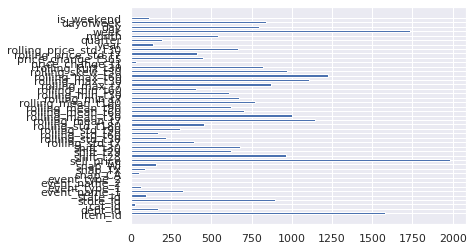

In [25]:
test, model = run_lgb(data)
# plot feature importance
pos = np.arange(len(features))
plt.barh(pos, model.feature_importance(),
                     align='center',
                     height=0.5,
                     tick_label=features)
plt.show()
predict(test, submission)